In [24]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [25]:
activity_name = ['climbing', 'diving', 'fishing', 'racing', 'throwing', 'vaulting']

train_dir = './data/train'
test_dir = './data/test'

train_image_paths = []
train_image_labels = []

for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    label = filename.split('_')[0]

    train_image_paths.append(image_path)
    train_image_labels.append(label)

test_image_paths = []
test_image_labels = []

for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    label = filename.split('_')[0]

    test_image_paths.append(image_path)
    test_image_labels.append(label)

In [26]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
])

def bias_swap(image1, image2, alpha=0.5):
    return alpha * image1 + (1 - alpha) * image2

In [27]:
label_mapping = {
    'climbing': 0,
    'diving': 1,
    'fishing': 2,
    'racing': 3,
    'throwing': 4,
    'vaulting': 5
}

def normalize_label(label):
    if label == 'pole vaulting':
        return 'vaulting'
    return label

class BAR_Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        normalized_label = normalize_label(label)
        numeric_label = label_mapping[normalized_label]

        if torch.rand(1).item() > 0.5:
            random_index = np.random.choice(len(self.image_paths))
            bias_image_path = self.image_paths[random_index]
            bias_image = Image.open(bias_image_path).convert("RGB")
            if self.transform:
                bias_image = self.transform(bias_image)

            image = bias_swap(image, bias_image)

        return image, torch.tensor(numeric_label)

In [28]:
train_dataset = BAR_Dataset(train_image_paths, train_image_labels, transform=transformer)
test_dataset = BAR_Dataset(test_image_paths, test_image_labels, transform=transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)

        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            return x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [31]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.7907
Epoch [2/100], Train Loss: 1.7893
Epoch [3/100], Train Loss: 1.7878
Epoch [4/100], Train Loss: 1.7865
Epoch [5/100], Train Loss: 1.7851
Epoch [6/100], Train Loss: 1.7838
Epoch [7/100], Train Loss: 1.7825
Epoch [8/100], Train Loss: 1.7813
Epoch [9/100], Train Loss: 1.7801
Epoch [10/100], Train Loss: 1.7790
Epoch [11/100], Train Loss: 1.7778
Epoch [12/100], Train Loss: 1.7767
Epoch [13/100], Train Loss: 1.7758
Epoch [14/100], Train Loss: 1.7749
Epoch [15/100], Train Loss: 1.7736
Epoch [16/100], Train Loss: 1.7727
Epoch [17/100], Train Loss: 1.7718
Epoch [18/100], Train Loss: 1.7710
Epoch [19/100], Train Loss: 1.7698
Epoch [20/100], Train Loss: 1.7688
Epoch [21/100], Train Loss: 1.7683
Epoch [22/100], Train Loss: 1.7673
Epoch [23/100], Train Loss: 1.7667
Epoch [24/100], Train Loss: 1.7659
Epoch [25/100], Train Loss: 1.7652
Epoch [26/100], Train Loss: 1.7644
Epoch [27/100], Train Loss: 1.7637
Epoch [28/100], Train Loss: 1.7631
Epoch [29/100], Train Loss: 1

Loss = `[1.7907, 1.7893, 1.7878, 1.7865, 1.7851, 1.7838, 1.7825, 1.7813, 1.7801, 1.779, 1.7778, 1.7767, 1.7758, 1.7749, 1.7736, 1.7727, 1.7718, 1.771, 1.7698, 1.7688, 1.7683, 1.7673, 1.7667, 1.7659, 1.7652, 1.7644, 1.7637, 1.7631, 1.7624, 1.7619, 1.7613, 1.7604, 1.7597, 1.7592, 1.7586, 1.7583, 1.7575, 1.7572, 1.7562, 1.7559, 1.7555, 1.7555, 1.7546, 1.7545, 1.7537, 1.7533, 1.7528, 1.7527, 1.7521, 1.7513, 1.7512, 1.7505, 1.7502, 1.7507, 1.7498, 1.7495, 1.7492, 1.7487, 1.7483, 1.7483, 1.7482, 1.7476, 1.7471, 1.7471, 1.7472, 1.7464, 1.7466, 1.7457, 1.7458, 1.7456, 1.7448, 1.7452, 1.7454, 1.7443, 1.7441, 1.7449, 1.7437, 1.7435, 1.7437, 1.743, 1.7432, 1.7425, 1.7432, 1.7426, 1.742, 1.7419, 1.7421, 1.7413, 1.7411, 1.7415, 1.7413, 1.7408, 1.7407, 1.7411, 1.7411, 1.7403, 1.7403, 1.7403, 1.7392, 1.7399]`

In [32]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 1.7471, Test Accuracy: 24.31%


In [33]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        return heatmap.cpu().detach().numpy()

def overlay_heatmap(heatmap, image_path, alpha=0.5):
    original_image = Image.open(image_path).convert("RGB")
    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_image.size, Image.BILINEAR)

    heatmap_colored = plt.cm.jet(np.array(heatmap_resized) / 255.0)[:, :, :3] * 255
    heatmap_colored = Image.fromarray(np.uint8(heatmap_colored))

    overlayed_image = Image.blend(original_image, heatmap_colored, alpha=alpha)
    return overlayed_image


In [34]:
def generate_and_visualize_heatmap(image_path, model, target_layer_name, class_idx=None):
    model.eval()

    transformer = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transformer(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer_name)

    outputs = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(outputs, dim=1).item()

    model.zero_grad()
    outputs[0, class_idx].backward()

    heatmap = grad_cam.generate_heatmap(class_idx)

    overlayed_image = overlay_heatmap(heatmap, image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Heat Map Overlay")
    plt.imshow(overlayed_image)
    plt.axis("off")
    plt.show()

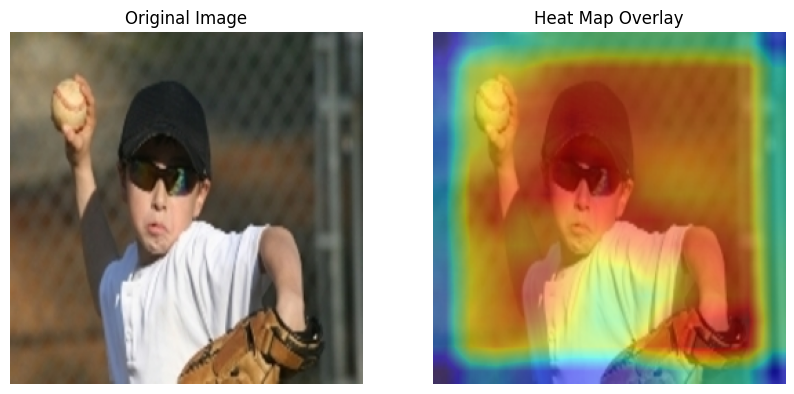

In [35]:
image_path = './data/test/throwing_321.jpg'
target_layer_name = 'conv6'
generate_and_visualize_heatmap(image_path, model, target_layer_name)